In [26]:
import os
import sys
sys.path.insert(1,os.path.abspath('../Git_Projects/0. Not_git/Sources/scikit-learn/0.23.2'))
import sklearn
print(sklearn.__version__)

0.23.2


### Load Data

In [27]:
import pandas as pd

# Input path and filename
path = 'D:/Git_Projects/5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '1.xlsx'
df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)

# Dependant variable
dep_var = 'Orders' 

# Set index
df = df.set_index("Date")

In [28]:
df

,Orders,CCI,CPI,Unemployment_rate,Long_term_interest_rates,Avg_Fuel_Price,TIV
Date,,,,,,,
2006-01-01,1124,100.83240,0.807265,8.3,3.280000,1.170000,20177
2006-02-01,1079,100.80160,0.901804,8.0,3.440000,1.186667,12845
2006-03-01,1210,100.60100,0.899101,7.7,3.620000,1.180000,15163
2006-04-01,1147,100.48250,1.297405,7.7,3.880000,1.243333,13472
2006-05-01,1001,100.56730,1.701702,7.9,3.940000,1.260000,16516
...,...,...,...,...,...,...,...
2022-08-01,254,94.58021,7.616082,7.2,1.624904,2.153333,8163
2022-09-01,228,94.10754,8.119296,7.3,2.420836,2.133333,7867
2022-10-01,188,93.96142,8.310766,6.4,2.894486,2.136667,7132


### Split Data

In [29]:
# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

start = train.index.min()
end = df.index.max()
start_test = test.index.min()

start, end, start_test

Dataset length : (n=204)
Train dates    : 2006-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=168)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)


(Timestamp('2006-01-01 00:00:00'),
 Timestamp('2022-12-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'))

### Pycaret

In [30]:
# Import the regression module
from pycaret.regression import *

#### Initialize

In [31]:
# Initialize setup
s = setup(    
    data = train, 
    test_data = test, 
    target = dep_var, 
    preprocess=True,  
    fold_strategy = 'timeseries', 
    transform_target = False, 
    data_split_shuffle=False,
    session_id = 42)

,Description,Value
0,session_id,42
1,Target,Orders
2,Original Data,"(168, 7)"
3,Missing Values,0
4,Numeric Features,6
5,Categorical Features,0
6,Ordinal Features,0
7,High Cardinality Features,0
8,High Cardinality Method,None
9,Transformed Train Set,"(168, 6)"


#### Model comparison

In [32]:
# Train and evaluate models
best = compare_models(exclude = ['dummy', 'br', 'knn', 'en', 'omp', 'huber'], sort = 'MSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,167.7616,51146.8483,211.8106,-1.9561,0.3641,0.3780,0.0230
lightgbm,Light Gradient Boosting Machine,171.5904,52478.6324,207.3520,-1.6755,0.3734,0.4321,0.3090
et,Extra Trees Regressor,168.9976,55929.3326,210.8237,-2.0558,0.3624,0.4069,0.0450
ridge,Ridge Regression,175.9674,60614.4712,207.8910,-2.3802,0.3748,0.4169,0.0120
rf,Random Forest Regressor,175.3499,61518.9541,219.1872,-2.4974,0.3719,0.4170,0.0540
gbr,Gradient Boosting Regressor,188.8359,63135.4986,229.0186,-2.6214,0.4003,0.4351,0.0140
xgboost,Extreme Gradient Boosting,178.3549,63210.8911,220.0666,-2.6312,0.3847,0.3955,0.0280
llar,Lasso Least Angle Regression,179.8280,64868.4590,212.5281,-2.1223,0.4113,0.4076,0.0090
par,Passive Aggressive Regressor,196.0841,67528.8007,226.8035,-1.7142,0.3387,0.3634,0.0080
lasso,Lasso Regression,197.7515,76554.8840,232.2810,-2.8975,0.4320,0.4565,0.4930


#### Create best model

In [33]:
# Create model
model = create_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,162.0422,55884.1240,236.3982,-0.2398,0.6107,0.6754
1,368.3383,179635.2961,423.8340,-9.8839,0.7694,1.1109
2,167.5340,43153.2733,207.7337,-1.1765,0.2793,0.2749
3,121.2715,25794.5098,160.6067,0.5460,0.2581,0.1691
4,93.9504,13610.4423,116.6638,-0.3689,0.2099,0.1636
5,138.0825,41578.9022,203.9091,-2.6195,0.3199,0.2392
6,137.3509,38324.4004,195.7662,0.0748,0.2896,0.2265
7,180.4777,50193.0825,224.0381,-2.6233,0.3205,0.3029
8,114.2615,19705.3936,140.3759,0.2399,0.2059,0.1806


#### Tune model

In [34]:
# Tune model
tuned_model = tune_model(model, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,165.0906,53165.8103,230.5771,-0.1794,0.6013,0.6652
1,321.1672,124873.1085,353.3739,-6.5659,0.6995,0.9709
2,156.2483,37419.3030,193.4407,-0.8873,0.2821,0.2660
3,109.4524,21640.0748,147.1057,0.6191,0.2476,0.1585
4,118.6889,20303.5763,142.4906,-1.0421,0.2719,0.2124
5,137.7251,39511.5019,198.7750,-2.4395,0.3209,0.2369
6,140.4277,39251.3397,198.1195,0.0524,0.2880,0.2248
7,176.4555,47081.1646,216.9819,-2.3986,0.3155,0.2936
8,111.8081,17901.4846,133.7964,0.3095,0.2025,0.1754


#### Plot model

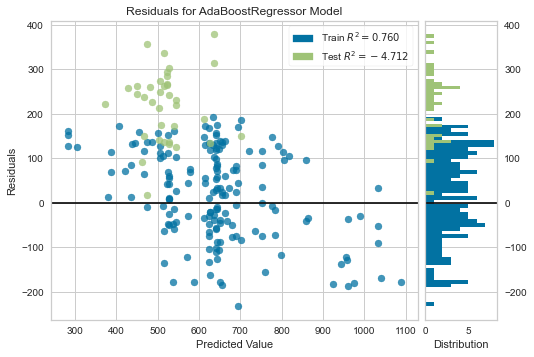

In [35]:
# PLot model - Residual plot
plot_model(model)

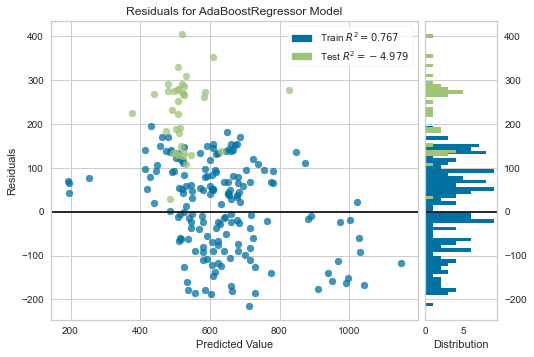

In [36]:
# PLot model - Residual plot
plot_model(tuned_model)

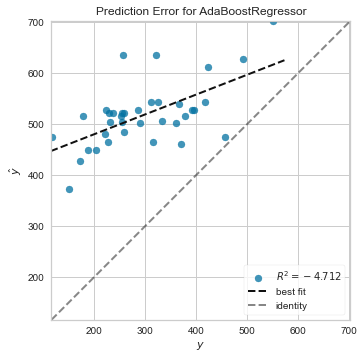

In [37]:
# Prediction Error Plot
plot_model(model, plot = 'error')

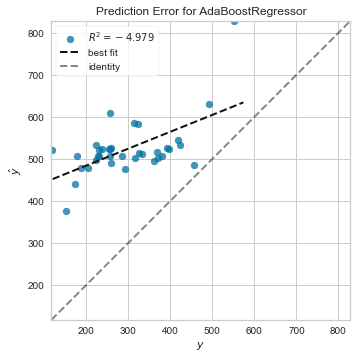

In [38]:
# Prediction Error Plot
plot_model(tuned_model, plot = 'error')

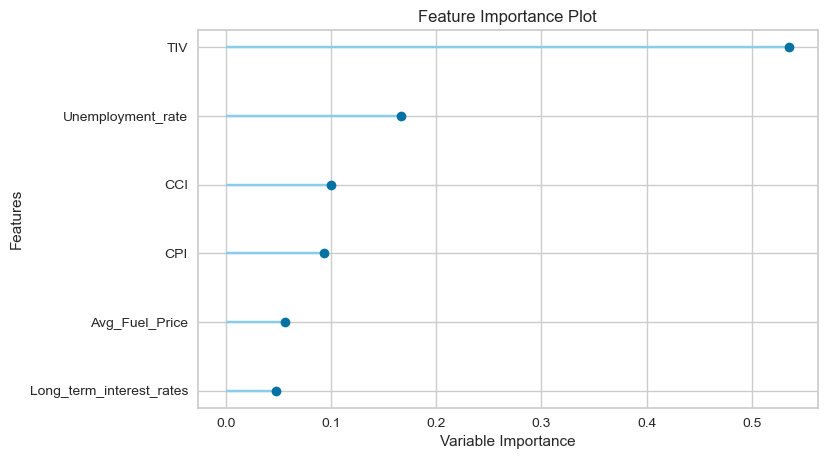

In [39]:
# Feature Importance Plot
plot_model(model, plot='feature')

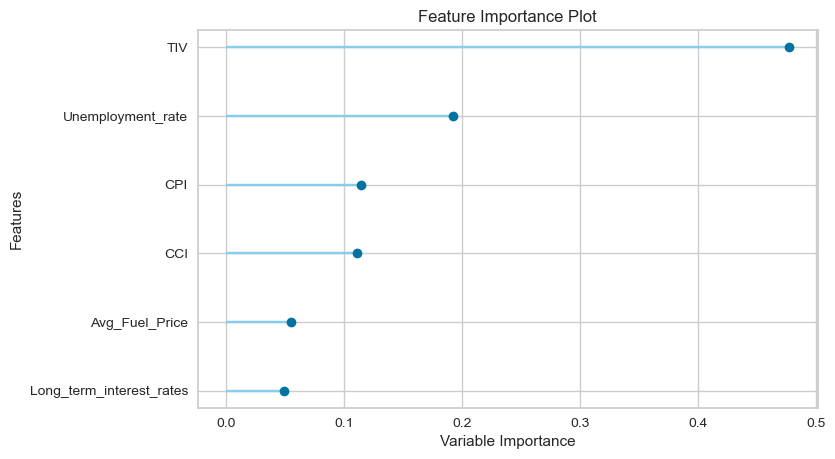

In [40]:
# Feature Importance Plot
plot_model(tuned_model, plot='feature')

#### Evaluate models

In [41]:
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [42]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#### Predict on test set

In [43]:
prediction = predict_model(model);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,220.6761,54687.3111,233.8532,-4.7117,0.6637,0.9039


In [44]:
prediction_tuned = predict_model(tuned_model);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,225.5942,57250.4837,239.2707,-4.9794,0.6760,0.9285


#### Predict full dataset

##### Base model

In [45]:
import plotly.express as px
# Generate predictions on the original dataset
predictions = predict_model(model, data=df)

# Add a date column in the dataset
predictions['Date'] = pd.date_range(start=start, end = end, freq = 'MS')

# Line plot
fig = px.line(predictions, x='Date', y=[dep_var, "Label"]) #, template = 'plotly_dark')

# Add a vertical rectange for test-set separation
fig.add_vrect(x0=start_test, x1=predictions.Date.max(), fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,111.1874,18386.5029,135.5968,0.6535,0.3356,0.3042


##### Tuned model

In [46]:
import plotly.express as px
# Generate predictions on the original dataset
predictions = predict_model(tuned_model, data=df)

# Add a date column in the dataset
predictions['Date'] = pd.date_range(start=start, end = end, freq = 'MS')

# Line plot
fig = px.line(predictions, x='Date', y=[dep_var, "Label"]) #, template = 'plotly_dark')

# Add a vertical rectange for test-set separation
fig.add_vrect(x0=start_test, x1=predictions.Date.max(), fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,111.5356,18575.1396,136.2906,0.6499,0.3310,0.2993


#### Finalize model

In [47]:
# Finalize the model i.e. train the best model on the entire dataset (this time, including the test set).
final = finalize_model(tuned_model)

In [48]:
final

AdaBoostRegressor(base_estimator=None, learning_rate=0.3, loss='square',
                  n_estimators=250, random_state=42)

In [49]:
# Review the transformed dataset
prep_pipe = get_config('prep_pipe') 
prep_pipe.transform(df) 

,CCI,CPI,Unemployment_rate,Long_term_interest_rates,Avg_Fuel_Price,TIV
Date,,,,,,
2006-01-01,100.832397,0.807265,8.3,3.280000,1.170000,20177.0
2006-02-01,100.801598,0.901804,8.0,3.440000,1.186667,12845.0
2006-03-01,100.600998,0.899101,7.7,3.620000,1.180000,15163.0
2006-04-01,100.482498,1.297405,7.7,3.880000,1.243333,13472.0
2006-05-01,100.567299,1.701702,7.9,3.940000,1.260000,16516.0
...,...,...,...,...,...,...
2022-08-01,94.580208,7.616082,7.2,1.624904,2.153333,8163.0
2022-09-01,94.107536,8.119296,7.3,2.420836,2.133333,7867.0
2022-10-01,93.961418,8.310766,6.4,2.894486,2.136667,7132.0
